# Libraries and Utilities

In [ ]:
!pip install plotly
!pip install Lifetimes

In [6]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
from lifetimes.plotting import plot_period_transactions
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load and Check Data

In [199]:
df = pd.read_csv('data.csv', header= 0, encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [114]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [98]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [108]:
df.shape

(541909, 8)

In [113]:
mv = pd.DataFrame(df.shape)
mv.index = ['Rows','Columns']
mv.columns = ['Size']
mv

,Size
Rows,541909
Columns,8


# Understanding Data

In [8]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'#'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'#'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'#'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'#'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'#'))
    print(dataframe.isnull().sum())
    print(" QUANTILES ".center(70,'#'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

############################### SHAPE ################################
Rows: 541909
Columns: 8
############################### TYPES ################################
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
################################ HEAD ################################
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8

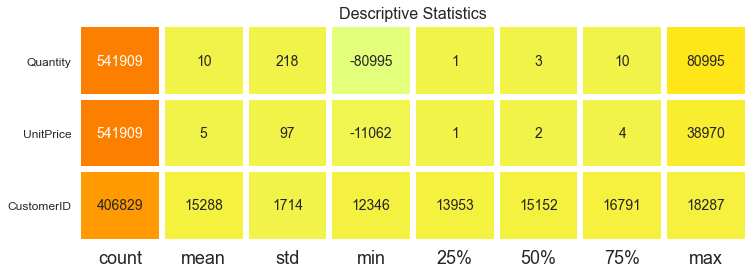

In [200]:
desc = df.describe().T
df1 = pd.DataFrame(index= [col for col in df.columns if df[col].dtype != 'O'], 
                   columns= ["count","mean","std","min","25%","50%","75%","max"],
                   data= desc )

f,ax = plt.subplots(figsize=(12,4))

sns.heatmap(df1, annot=True,cmap = "Wistia", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 14})

plt.xticks(size = 18)
plt.yticks(size = 12, rotation = 0)
plt.title("Descriptive Statistics", size = 16)
plt.show()

In [201]:
df = df[df["Quantity"] > 0]

In [202]:
df.dropna(inplace=True)
print('Missing Values: {}'.format(df.isnull().sum().sum()))

Missing Values: 0


In [203]:
df = df[~df["InvoiceNo"].str.contains("C", na=False)]

In [204]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [205]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

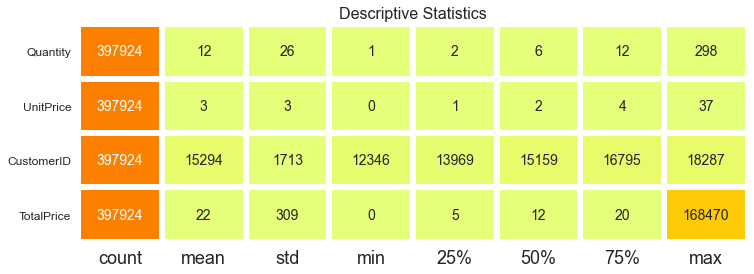

In [206]:
desc = df.describe().T
df1 = pd.DataFrame(index= [col for col in df.columns if df[col].dtype != 'O'], 
                   columns= ["count","mean","std","min","25%","50%","75%","max"],
                   data= desc )

f,ax = plt.subplots(figsize=(12,4))

sns.heatmap(df1, annot=True,cmap = "Wistia", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 14})

plt.xticks(size = 18)
plt.yticks(size = 12, rotation = 0)
plt.title("Descriptive Statistics", size = 16)
plt.show()

In [207]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [122]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda invoice_date: (today_date - invoice_date.max()).days,
                                    'InvoiceNo': lambda invoice: invoice.nunique(),
                                    'TotalPrice': lambda total_price: total_price.sum()})

rfm.columns = ['Recency','Frequency','Monetary']
rfm = rfm.reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


In [208]:
rfm['recency_score'] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])

rfm['frequency_score'] = pd.qcut(rfm['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])

rfm['monetary_score'] = pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])

rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str)+ rfm['frequency_score'].astype(str))

In [209]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,k_means_segment
0,12346.0,326,1,77183.60,1,1,5,11,hibernating,1
1,12347.0,3,7,4310.00,5,5,5,55,champions,0
2,12348.0,76,4,1797.24,2,4,4,24,at_Risk,0
3,12349.0,19,1,1757.55,4,1,4,41,promising,2
4,12350.0,311,1,334.40,1,1,2,11,hibernating,1


In [210]:
rfm[['Recency','Monetary','Frequency','segment']].groupby('segment').agg({'mean','std','max','min'})

Recency                           Monetary             \
                           std  max min        mean           std        max   
segment                                                                        
about_to_sleep       10.943474   72  34   53.312500    533.590577    6207.67   
at_Risk              68.618828  374  73  153.785835   2562.073355   44534.30   
cant_loose           65.250378  373  73  132.968254   2090.489984   10254.18   
champions             3.683300   13   1    6.361769  20339.772225  280206.02   
hibernating          92.013560  374  73  217.605042   2419.682627   77183.60   
loyal_customers      15.577050   72  15   33.608059   6007.061883  124914.53   
need_attention       11.552074   72  34   52.427807   1102.503394   12601.83   
new_customers         3.902112   13   1    7.428571    570.776294    3861.00   
potential_loyalists   9.338808   33   1   17.398760   7656.323881  168472.50   
promising             5.238115   33  15   23.421053    241.019513    1757.55   

                                          Frequency                      
                        min         mean        std  max min       mean  
segment                                                                  
about_to_sleep         6.20   471.994375   0.368913    2   1   1.161932  
at_Risk               52.00  1084.535297   0.954415    6   2   2.878583  
cant_loose            70.02  2796.155873   4.289630   34   6   8.380952  
champions            201.12  6857.935482  16.476484  210   3  12.417062  
hibernating            3.75   488.643307   0.302492    2   1   1.101774  
loyal_customers       36.56  2864.247791   4.545669   63   3   6.479853  
need_attention         6.90   897.627861   0.470081    3   2   2.326203  
new_customers         89.94   388.212857   0.000000    1   1   1.000000  
potential_loyalists   20.80  1041.222004   0.651401    3   1   2.010331  
promising              0.00   290.913158   0.000000    1   1   1.000000

In [211]:
data = go.Bar(y = pd.DataFrame(rfm['segment'].value_counts()).index,
              x = pd.DataFrame(rfm['segment'].value_counts())['segment'].values,
              name = str(pd.DataFrame(rfm['segment'].value_counts())['segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1300])
iplot(fig)

In [127]:
fig = go.Figure()
for i in rfm['segment'].unique():
    fig.add_trace(go.Scatter(x=rfm[rfm['segment']==i]['Recency'],
                           y=rfm[rfm['segment']==i]['Frequency'],
                           mode='markers', name=str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                  legend=dict(x=0.8,y=1,bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show()

In [128]:
kmeans_data = rfm.loc[:,['recency_score','frequency_score']]

inertia=[]
k = [1,2,3,4,5,6,7,8,9]
for i in k:
    kmean=KMeans(n_clusters=i)
    kmean.fit(kmeans_data)
    inertia.append(kmean.inertia_)
    
data = go.Scatter(x=k, y=inertia,mode='lines+markers',marker=dict(size=10))

layout = go.Layout(title={'text': "Elbow Method",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   width=650,height=470,
                   xaxis = dict(title='Number of Clusters'),
                   yaxis =dict(title='Sum of Squared Distance'),
                   template = 'plotly_white')

fig =go.Figure(data=data,layout=layout)
iplot(fig)

In [129]:
kmeans = KMeans(n_clusters = 3,random_state = 42)
kmeans.fit(kmeans_data)
print('Silhouette Score: {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_),3)))

Silhouette Score: 0.447


In [130]:
rfm['k_means_segment'] = kmeans.labels_
rfm['k_means_segment'] = rfm['k_means_segment'].astype(str)
data = go.Bar(y = pd.DataFrame(rfm['k_means_segment'].value_counts()).index,
              x = pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values,
              name = str(pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by K-Means Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1900])
iplot(fig)

In [131]:
fig = go.Figure()
for i in rfm['k_means_segment'].unique():
    fig.add_trace(go.Scatter(x=rfm[rfm['k_means_segment']==i]['Recency'],
                           y=rfm[rfm['k_means_segment']==i]['Frequency'],
                           mode='markers', name='Segment: '+str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by K-Means Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                  legend=dict(x=0.8,y=1,bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show()

In [132]:
today_date = dt.datetime(2011,12,11)

cltv_df = df.groupby('CustomerID').agg({'InvoiceDate': [lambda invoice_date: (invoice_date.max() - invoice_date.min()).days,
                                                        lambda invoice_date: (today_date - invoice_date.min()).days], 
                                        'InvoiceNo': lambda invoice: invoice.nunique(),
                                        'TotalPrice': lambda total_price: total_price.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.0,0,326,1,77183.60
12347.0,365,368,7,4310.00
12348.0,282,359,4,1797.24
12349.0,0,19,1,1757.55
12350.0,0,311,1,334.40


In [133]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [134]:
cltv_df = cltv_df[cltv_df["monetary"] > 0]

In [135]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [136]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [137]:
cltv_df

,recency,T,frequency,monetary
CustomerID,,,,
12347.0,52.142857,52.571429,7,615.714286
12348.0,40.285714,51.285714,4,449.310000
12352.0,37.142857,42.428571,8,313.255000
12356.0,43.142857,46.571429,3,937.143333
12358.0,21.285714,21.571429,2,584.030000
...,...,...,...,...
18272.0,34.857143,35.285714,6,513.096667
18273.0,36.428571,36.857143,3,68.000000
18282.0,16.857143,18.142857,2,89.025000


In [138]:
bgf = BetaGeoFitter(penalizer_coef=0.001) #avoid overfitting

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [142]:
bg_nbd= pd.DataFrame(bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10))
bg_nbd.columns = ['İşlem Sayısı']
bg_nbd

,İşlem Sayısı
CustomerID,
12748.0,3.265158
14911.0,3.126645
17841.0,1.940290
13089.0,1.537528
14606.0,1.463999
15311.0,1.433717
12971.0,1.357024
14646.0,1.222517
13408.0,0.986249


In [31]:
bgf.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    13.025670
14911.0    12.473095
17841.0     7.740345
13089.0     6.133456
14606.0     5.840269
15311.0     5.719467
12971.0     5.413481
14646.0     4.876360
13408.0     3.934373
18102.0     3.863856
dtype: float64

In [32]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1777.145073163697

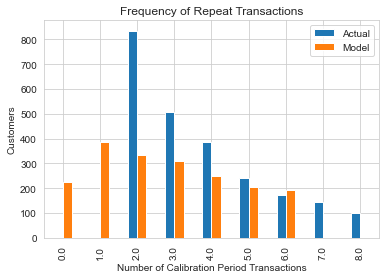

In [33]:
plot_period_transactions(bgf)
plt.show()

In [34]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.72>

In [144]:
gamma_gamma = pd.DataFrame(ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10))
gamma_gamma.columns = ['Ortalama Kar']
gamma_gamma

,Ortalama Kar
CustomerID,
16446.0,92241.347482
15749.0,15757.463973
15098.0,14123.695740
12415.0,5998.051889
12590.0,5402.759893
12536.0,4459.821138
16000.0,4386.185168
18102.0,4340.236368
12435.0,4288.934927


In [155]:
cltv = ggf.customer_lifetime_value(bgf,cltv_df['frequency'],
                                   cltv_df['recency'],cltv_df['T'],
                                   cltv_df['monetary'],time=6,
                                   freq="W",discount_rate=0.01)

In [156]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,CustomerID,clv
1970,16446.0,222031.360150
1122,14646.0,114426.177030
2761,18102.0,103724.312719
2458,17450.0,78292.523250
843,14096.0,68017.083243
36,12415.0,56091.077927
1257,14911.0,55268.218394
874,14156.0,46362.988847
1754,16000.0,42991.457509
2487,17511.0,37092.423491


In [157]:
cltv_df.reset_index()

,CustomerID,recency,T,frequency,monetary
0,12347.0,52.142857,52.571429,7,615.714286
1,12348.0,40.285714,51.285714,4,449.310000
2,12352.0,37.142857,42.428571,8,313.255000
3,12356.0,43.142857,46.571429,3,937.143333
4,12358.0,21.285714,21.571429,2,584.030000
...,...,...,...,...,...
2840,18272.0,34.857143,35.285714,6,513.096667
2841,18273.0,36.428571,36.857143,3,68.000000
2842,18282.0,16.857143,18.142857,2,89.025000
2843,18283.0,47.571429,48.285714,16,130.930000


In [158]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv[["clv"]])
cltv["scaled_clv"] = scaler.transform(cltv[["clv"]])

cltv["segment"] = pd.qcut(cltv["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv.head()

,CustomerID,clv,scaled_clv,segment
0,12347.0,2200.757812,0.009912,A
1,12348.0,1066.014209,0.004801,B
2,12352.0,1436.987032,0.006472,B
3,12356.0,2109.557658,0.009501,A
4,12358.0,1899.144305,0.008553,A


In [196]:
cltv['clv'].max()

222031.36015013055

In [45]:
cltv_final = cltv_df.merge(cltv, on="CustomerID", how="left")
cltv_final

,CustomerID,recency,T,frequency,monetary,clv,scaled_clv,segment
0,12347.0,52.142857,52.571429,7,615.714286,2201.132898,0.009907,A
1,12348.0,40.285714,51.285714,4,449.310000,1066.336982,0.004800,B
2,12352.0,37.142857,42.428571,8,313.255000,1437.198033,0.006469,B
3,12356.0,43.142857,46.571429,3,937.143333,2110.430236,0.009499,A
4,12358.0,21.285714,21.571429,2,584.030000,1900.354867,0.008553,A
...,...,...,...,...,...,...,...,...
2840,18272.0,34.857143,35.285714,6,513.096667,2229.022712,0.010033,A
2841,18273.0,36.428571,36.857143,3,68.000000,187.810498,0.000845,D
2842,18282.0,16.857143,18.142857,2,89.025000,325.961029,0.001467,D
2843,18283.0,47.571429,48.285714,16,130.930000,985.627122,0.004436,C


In [194]:
cltv_final['clv'].max()

108691.79760985654

In [161]:
cltv_final[['recency','monetary','frequency','segment']].groupby('segment').agg({'mean','std','count','sum'})

recency                                   monetary                 \
               std           sum       mean count         std            sum   
segment                                                                        
D        15.276451  15705.142857  22.057785   712  120.789632  130733.013924   
C        14.120070  21747.142857  30.586699   711  122.249514  193055.954775   
B        15.809895  20974.142857  29.499498   711  220.969687  265857.464708   
A        17.910064  22414.428571  31.525216   711  530.374913  469090.096231   

                           frequency                         
               mean count        std   sum       mean count  
segment                                                      
D        183.613784   712   2.351615  2183   3.066011   712  
C        271.527363   711   2.443461  2909   4.091421   711  
B        373.920485   711   3.587453  3856   5.423347   711  
A        659.761035   711  16.198599  8094  11.383966   711

In [162]:
fig = go.Figure()
for i in cltv_final['segment'].unique():
    fig.add_trace(go.Scatter(x=cltv_final[cltv_final['segment']==i]['recency'],
                           y=cltv_final[cltv_final['segment']==i]['frequency'],
                           mode='markers', name=str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                  legend=dict(x=0.8,y=1,bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show()

In [163]:
data = go.Bar(x = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['segment'],
              y = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],
              text = round(cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],3),
              textposition= 'auto',
              marker = dict(color = 'darkorange'))

layout = go.Layout(title={'text': "Average CLV by Segments",'y':0.9,'x':0.5,
                          'xanchor': 'center','yanchor': 'top'},
                   xaxis = dict(title='Segment'),
                   yaxis =dict(title='CLV'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_yaxes(range=[0,5100])
iplot(fig)

In [168]:
# data = pd.read_csv('data.csv', header= 0, encoding= 'unicode_escape')

# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [169]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()


data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [171]:
cltv.head()

,CustomerID,clv,scaled_clv,segment
0,12347.0,2200.757812,0.009912,A
1,12348.0,1066.014209,0.004801,B
2,12352.0,1436.987032,0.006472,B
3,12356.0,2109.557658,0.009501,A
4,12358.0,1899.144305,0.008553,A


In [173]:
from plotly.subplots import make_subplots

In [189]:
fig = make_subplots(rows=2,cols=2,subplot_titles=("A", "B",'C','D'))

fig.add_trace(go.Box(y =cltv[cltv['segment']=='A']['clv'],showlegend=False,
                     name = 'A',marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='B']['clv'],showlegend=False,
                     name = 'B',marker_color='#1760E1'),row=1,col=2)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='C']['clv'],showlegend=False,
                     name = 'C',marker_color='#1760E1'),row=2,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='D']['clv'],showlegend=False,
                     name = 'D',marker_color='#1760E1'),row=2,col=2)


fig.update_layout(title={'text': "CLTV by SEGMENTS",'y':0.9,'x':0.5,'xanchor': 'center',
        'yanchor': 'top'},template='plotly')      
iplot(fig)

In [187]:
data = go.Box(y=cltv_final[cltv_final['segment']=='A']['clv'],name = 'A',marker_color='#F513C1')
layout = go.Layout(title={'text': "A",'y':0.9,'x':0.5,'xanchor': 'center',
        'yanchor': 'top'}, width = 450, height=1000)
fig = go.Figure(data = data, layout=layout)
iplot(fig)

In [181]:
cltv_final

,CustomerID,recency,T,frequency,monetary,level_0,index,clv,scaled_clv,segment
0,12347.0,52.142857,52.571429,7,615.714286,0,0,2200.757812,0.020248,A
1,12348.0,40.285714,51.285714,4,442.695000,1,1,1050.352232,0.009664,B
2,12352.0,37.142857,42.428571,8,219.542500,2,2,1007.740705,0.009272,B
3,12356.0,43.142857,46.571429,3,937.143333,3,3,2109.557658,0.019409,A
4,12358.0,21.285714,21.571429,2,575.210000,4,4,1870.554771,0.017210,A
...,...,...,...,...,...,...,...,...,...,...
2840,18272.0,34.857143,35.285714,6,513.096667,2840,2840,2228.578773,0.020504,A
2841,18273.0,36.428571,36.857143,3,68.000000,2841,2841,187.740604,0.001727,D
2842,18282.0,16.857143,18.142857,2,89.025000,2842,2842,325.767418,0.002997,D
2843,18283.0,47.571429,48.285714,16,130.930000,2843,2843,985.558116,0.009067,C


In [192]:
cltv[cltv['segment']=='A']['clv'].max()

222031.36015013055